In [1]:
# -*- coding: utf8

from IPython.display import HTML
from matplotlib import animation
from scipy import stats as ss

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Para evitar a confusão da aula passada, colocando alguns defaults!
plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [2]:
plt.ion()

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

In [3]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

# Aula 08 - Intervalos de Confiança e Bootstrap

## Introdução, mais uma vez o TCL

Vamos explorar a ideia de intervalos de confiança. Inicialmente, lembre-se do teorema central do limite que diz: se $X_1, ..., X_n$ são variáveis aleatórias. Em particular, todas as VAs foram amostradas de uma mesma população com média $\mu$ (finita), desvio padrão $\sigma$ (finito). Além do mais, a geração de cada VA é independente da outra, sendo toas identicamente distribuídas. Quando $n$ é grande, então

$$\frac{1}{n}(X_1 + \cdots + X_n)$$

é aproximadamente distribuído por uma Normal com média $\mu$ e desvio padrão $\sigma/\sqrt{n}$:

$$\frac{1}{n}(X_1 + \cdots + X_n) \sim Normal(\mu, \sigma/\sqrt{n})$$.

## Distribuição amostral e Intervalos de Confiança

A distribuição dos valores de uma estatística a partir de amostras é chamada de *distribuição amostral* daquela estatística. Ela tem um papel importante, porque é a partir do entendimento dela que estimaremos quanta confiança temos em uma estatística que estamos calculando a partir de uma amostra. No exemplo acima, cada $X_i$ é uma amostra e $X_i/n$ é a média desta amostra. Então, $\frac{1}{n}(X_1 + \cdots + X_n)$ é a distribuição amostral das médias!

O principal a entender aqui é que se conhecermos a distribuição amostral, saberemos quão longe normalmente a estatística calculada para uma amostra está daquela calculada para a população. Sabendo isso, podemos calcular uma margem de erro para a estimativa feita a partir da amostra, tal estimativa será o nosso intervalo de confiança.

Vamos iniciar com um caso que conheçemos a distribuição da população.

## Exemplo Moedas (Caso onde Sabemos da População!)

**É importante falar que por um bom tempo este notebook não vai computar ICs, preste atenção no fluxo de ideias.**

Por simplicidade, vamos fazer uso um exemplo de lançamento de moedas. Isto é, vamos explorar a probabilidade de uma moeda ser justa usando estatística e amostragem (conceitos não exclusivos).

Lembrando, temos um espaço amostral:

\begin{align}
\mathcal{S} &= \{h, t\} \\
P(h) &= 0.5 \\
P(t) &= 0.5
\end{align}

No caso das moedas é simples saber a **distribuição da população**. O número de sucessos de lançamentos de uma moeda segue uma distribuição Binomial. A mesma se parece bastante com a Normal. A PMF de uma Binomial é:

$$p(n \mid k) = \binom{n}{k} p^k (1-p)^{n-k}$$

onde $n$ captura o número de caras e $k$ o número de lançamentos.

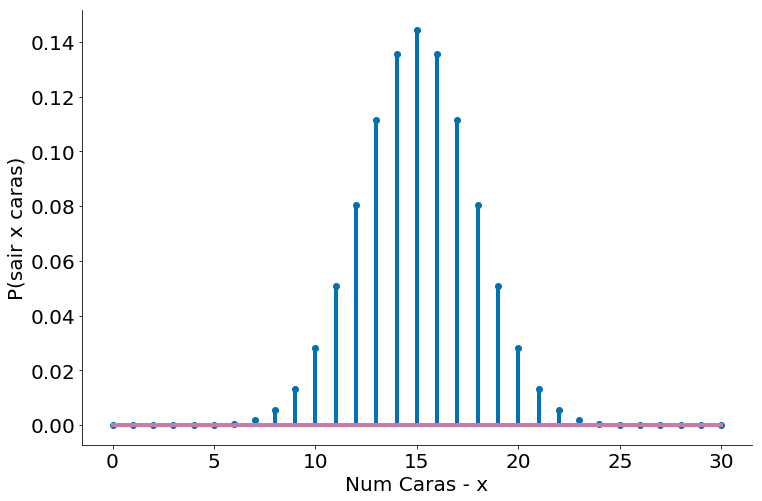

In [4]:
p = 0.5 # probabilidade de heads/tails
k = 30  # temos 30 jogadas
x = np.arange(0, 31) # Valores no eixo x
prob_binom = ss.distributions.binom.pmf(x, k, p)
plt.stem(x, prob_binom)
plt.xlabel('Num Caras - x')
plt.ylabel('P(sair x caras)')
despine()

Usando a função `ppf` podemos ver onde ficam $95\%$ dos lançamentos de moedas. Para isto, temos que considerar $2.5\%$ para a esquerda e $2.5\%$ para a direita.

A `ppf` pode é inverso da CDF. Pegamos valor no percentil, não o percentil dado um valor.

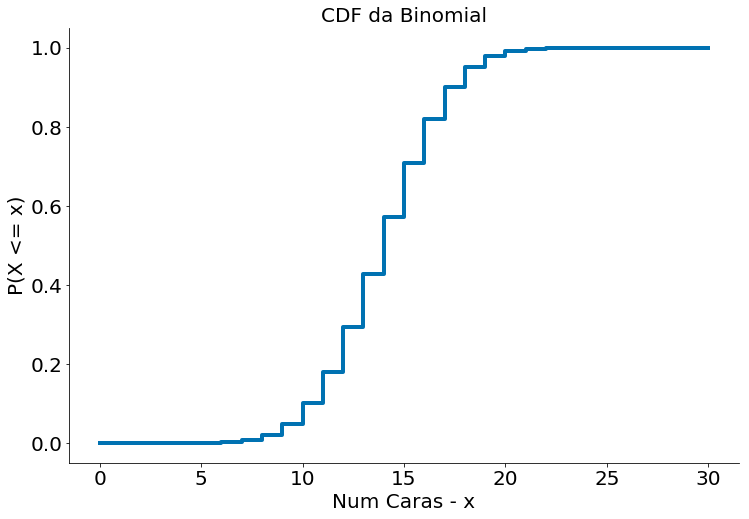

In [5]:
p = 0.5 # probabilidade de heads/tails
k = 30  # temos 30 jogadas
x = np.arange(0, 31) # Valores no eixo x
prob_binom = ss.distributions.binom.cdf(x, k, p)
plt.step(x, prob_binom)
plt.xlabel('Num Caras - x')
plt.ylabel('P(X <= x)')
plt.title('CDF da Binomial')
despine()

In [6]:
# 2.5% dos dados P[X <= 10] = 0.025
ss.distributions.binom.ppf(0.025, k, p)

10.0

In [7]:
print(1-0.025)
# 2.5% dos dados para cima P[X > 20] = 0.025
ss.distributions.binom.ppf(1-0.025, k, p)

0.975


20.0

**Caso 1: Quando sabemos a população é fácil responder a pergunta**

$95\%$ dos lançamentos de 30 moedas justas deve cair entre 10 e 20. Acamos de computar lá em cima usando o inverso da CDF `a PPF`.

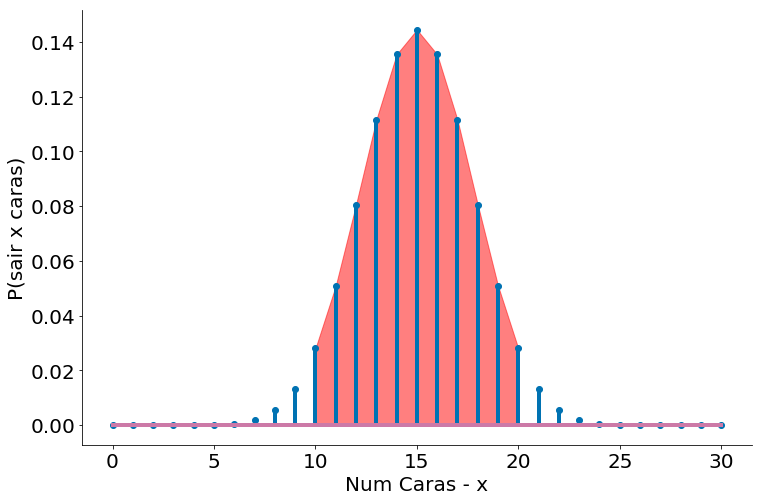

In [8]:
p = 0.5 # probabilidade de heads/tails
k = 30  # temos 30 jogadas
x = np.arange(0, 31) # Valores no eixo x
prob_binom = ss.distributions.binom.pmf(x, k, p)
plt.stem(x, prob_binom)
plt.xlabel('Num Caras - x')
plt.ylabel('P(sair x caras)')
despine()

x2 = np.arange(10, 21) # Valores no eixo x
prob_binom = ss.distributions.binom.pmf(x2, k, p)
plt.fill_between(x2, prob_binom, color='r', alpha=0.5)

## Simulando

Agora, vamos assumir que não sei disto. Isto é, não sei nada de ppf, pdf, pmf, cdf etc. Mas eu sei jogar moedas para cima. Será que consigo estimar o mesmo efeito?!

In [9]:
# Jogando uma única moeda
np.random.randint(2)

1

In [10]:
# Jogando 30 moedas
np.random.randint(0, 2, size=30)

array([1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0])

Text(0, 0.5, 'Fração de Casos')

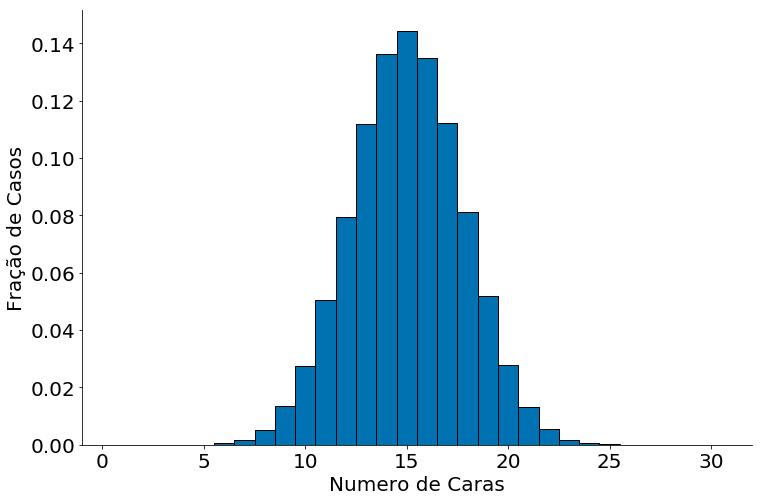

In [11]:
NUM_SIMULACOES = 100000
resultados = []
for i in range(NUM_SIMULACOES):
    jogadas = np.random.randint(0, 2, size=30) # joga 30 moedas para cima
    n_caras = (jogadas == 1).sum()             # conta quantas foram == 1, caras
    resultados.append(n_caras)
bins = np.arange(0, 31) + 0.5
plt.hist(resultados, density=True, bins=bins, edgecolor='k');
despine()
plt.xlabel('Numero de Caras')
plt.ylabel('Fração de Casos')

**Caso 2: Quando sabemos gerar dados que seguem a população é fácil responder a pergunta.**

Podemos verificar o resultado empiricamente na CDF. Estou usando `side='left'` pois por motivos que não entendo o statsmodels faz `P[X < x]` e não `P[X <= x]` por default. Com side `left` corrigimos isto.

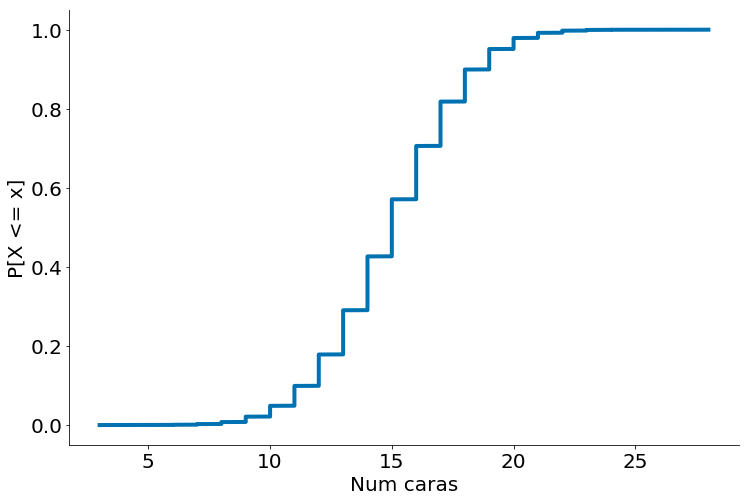

In [12]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(resultados, side='left')

plt.plot(ecdf.x, ecdf.y)
plt.xlabel('Num caras')
plt.ylabel('P[X <= x]')
despine()

In [13]:
np.percentile(resultados, 2.5)

10.0

In [14]:
np.percentile(resultados, 97.5)

20.0

In [15]:
ecdf(10)

0.021160000000000002

In [16]:
ecdf(21)

0.97897000000000001

Até agora eu estou assumindo muito.

1. Sei da população
1. Sei amostrar de forma uniforme da população.

E quando eu estiver apenas com 1 amostra?!

## Quando não sabemos de muita coisa

**Preste atenção a partir daqui**

Não sei nem jogar uma moeda para cima. Desempilhe o TCL.

Lembre-se que distribuição Binomial captura a **média** de caras esperadas em _n_  lançamentos. Note que, ao somar cada um dos meus experimentos estou justamente voltando para o **TCL**. A distribuição amostral aqui é a média de caras a cada 30 jogadas. Assim, podemos ver a aproximação abaixo.

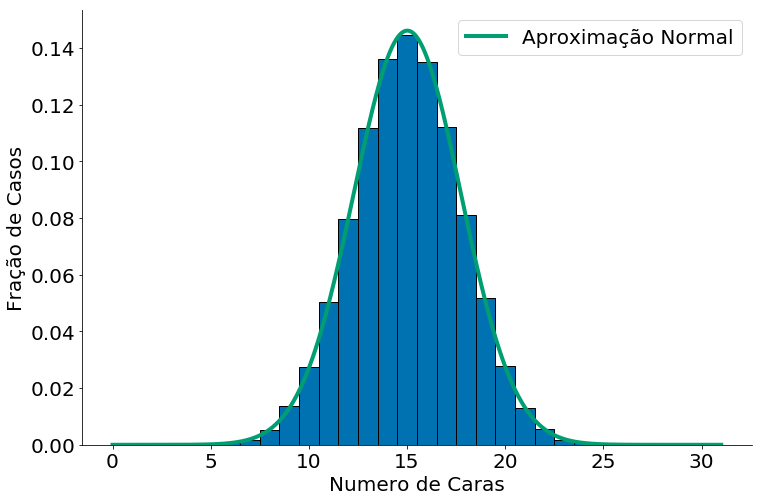

In [17]:
bins = np.arange(0, 31) + 0.5
plt.hist(resultados, density=True, bins=bins, edgecolor='k');
plt.xlabel('Numero de Caras')
plt.ylabel('Fração de Casos')

x = np.linspace(0, 31, 1000)
y = ss.distributions.norm.pdf(loc=np.mean(resultados),
                              scale=np.std(resultados, ddof=1), ## ddof=1 faz dividir por n-1
                              x=x)
plt.plot(x, y, label='Aproximação Normal')
plt.legend()
despine()

## ICs com Normal

Considere o caso que tenho **UMA** amostra apenas. Aqui eu não tenho mais distribuição amostral, pois só fiz uma coleta de dados. Felizmente, eu tenho algo para me ajudar, o TCL.

Quando o TCL funciona, podemos computar o intervalo de confiança usando uma Normal. Essa é a base comum que motivamos algumas aulas atrás. Vamos brincar um pouco de shiftar/escalar nossa Normal. Sabendo que:

$$\frac{1}{n}(X_1 + \cdots + X_n) \sim Normal(\mu, \sigma/\sqrt{n}).$$

Vamos fazer:

$$Z_i = X_i - \mu$$

Note que estamos apenas jogando todo mundo para a esquerda $-\mu$. O valor esperado (média) de uma VA X, $E[x]$, menos uma constante $c$ nada mais é do que $E[x]-c$. Além do mais, a variânçia não muda. Veja as propriedades no Wikipedia. 

Assim:

$$\frac{1}{n}\sum_i Z_i = \frac{1}{n}\sum_i X_i - \mu \sim Normal(0, \sigma/\sqrt{n})$$

Agora, vamos dividir $Z_i$ por. Neste caso, o desvio padrão e a média vão ser divididos pelo mesmo valor:

$$\frac{1}{n}\sum_i Z_i = \frac{1}{n}\sum_i \frac{X_i - \mu}{\sigma/\sqrt{n}} \sim Normal(0, 1)$$

Isto quer dizer que **a média** (note a soma e divisão por n) das **distribuições amostrais** $Z_i$ seguem uma $Normal(0, 1)$. Note que estamos assumindo que o TCL está em voga. Às vezes (quando quebramos IID ou Variância finita), o mesmo não vale, mas vamos ignorar tais casos. Bacana, e daí? **Não importa a população inicial, essa é a beleza do TCL!**. 

Então, mesmo sem saber a média real da população $\mu$, eu posso brincar com a equação acima. Primeiramente vamos focar na média $\frac{1}{n}\sum_i Z_i$, vamos chamar esta distribuição de $Z$ apenas. Sabendo que uma população segue uma Normal, eu consigo facilmente saber onde caem 95\% dos casos. Isto é similar ao exemplo das moedas e da Binomial acima. Porém, note que eu não assumo nada da população dos dados. 

Uma forma comum de computar tais intervalos é usando tabelas ou uma figura como a apresentada abaixo. Hoje em dia, podemos usar a função `ppf`. A mesma indica que 95% dos casos estão ente $-1.96$ e $1.96$. 

![](normal.gif)

In [18]:
ss.norm.ppf(0.975)

1.959963984540054

In [19]:
ss.norm.ppf(1-0.975)

-1.959963984540054

Agora eu preciso apenas voltar para $X$. Para tal, vamos fazer uso de estimador não viésado de $\sigma$, o desvio padrão da amostra.

$$s = \sqrt{\frac{\sum_i ({x_i - \bar{x}})^2}{n-1}}$$

Fazendo $z=1.96$ e $P(-z \le Z \le z) = 0.95$

\begin{align}
0.95 & = P(-z \le Z \le z)=P \left(-1.96 \le \frac {\bar X-\mu}{\sigma/\sqrt{n}} \le 1.96 \right) \\
& = P \left( \bar X - 1.96 \frac \sigma {\sqrt{n}} \le \mu \le \bar X + 1.96 \frac \sigma {\sqrt{n}}\right).
\end{align}

Substituindo $\sigma$ por $s$: a probabilidade da média da população está entre $\bar{X} +- 1.96 \frac \sigma {\sqrt{n}}$ é de 95%. 

1. https://en.wikipedia.org/wiki/Variance#Properties
1. https://en.wikipedia.org/wiki/Expected_value#Basic_properties

## Computando um IC dos dados

In [20]:
# brinque com este valor um pouco, observe a mudança nas células abaixo.

TAMANHO_AMOSTRA = 100
resultados = []
for i in range(TAMANHO_AMOSTRA):
    jogadas = np.random.randint(0, 2, size=30) # joga 30 moedas para cima
    n_caras = (jogadas == 1).sum()             # conta quantas foram == 1, caras
    resultados.append(n_caras)

In [21]:
s = np.std(resultados, ddof=1)
s

2.5427853971103374

In [22]:
s_over_n = s / np.sqrt(len(resultados))
s_over_n

0.25427853971103376

In [23]:
mean = np.mean(resultados)
mean

14.83

In [24]:
mean - 1.96 * s_over_n

14.331614062166373

In [25]:
mean + 1.96 * s_over_n

15.328385937833627

In [26]:
# até aqui.

## Entendendo um IC

Diferente de quando temos uma distribuição populacional, temos que interpretar o IC diferente. Note que:

1. **Não estamos computando onde caem 95% dos casos da população**. Basta comparar os valores acima.
1. **Não estamos computando onde caem 95% das médias**. Bast comparar com os valores acima.

Estamos computando resolvendo:

$$P(-z \le Z \le z)=P \left(-1.96 \le \frac {\bar X-\mu}{\sigma/\sqrt{n}} \le 1.96 \right)$$

E chegando em:

$$P \left( \bar X - 1.96 \frac \sigma {\sqrt{n}} \le \mu \le \bar X + 1.96 \frac \sigma {\sqrt{n}}\right)$$

Ou seja:

**A PROBABILIDADE DA MÉDIA REAL $\mu$ CAIR ENTRE $X +- 1.96 \frac \sigma {\sqrt{n}}$ É DE 95%**

ou

**EU TENHO 95% DE CONFIANÇA DE QUE A MÉDIA ESTÁ ENTRE $X +- 1.96 \frac \sigma {\sqrt{n}}$**

ou

**95% DAS AMOSTRAS DE TAMANHO N VÃO CONTER A MÉDIA REAL**

ou 

**95% DAS AMOSTRAS DE TAMANHO N VÃO CONTER VALORES ENTRE $X +- 1.96 \frac \sigma {\sqrt{n}}$**

In [27]:
# Construindo um IC
(mean - 1.96 * s_over_n, mean + 1.96 * s_over_n)

(14.331614062166373, 15.328385937833627)

**95% dos intervalos de tamanho n ficam na faixa acima. O mesmo não inclui o 22, então podemos assumir que o valor é não esperado.**

Observe que existe uma chance de cometermos erros, qual é?

## A situação mais comum na vida real

Normalmente temos *uma amostra* da população apenas. Daí não conhecemos a distribuição amostral. Mas gostaríamos de a partir da nossa amostra estimar onde está a estatística para a população. 

Exemplo: queremos estimar qual a proporção de pessoas que gostará do produto (a estatística) entre todos os usuários (a população) a partir do cálculo da proporção de pessoas que gostou do produto (a mesma estatística) em um teste com 100 pessoas (a amostra).

Repare que se conhecermos como a estatística varia na distribuição amostral (ex: 2 pontos pra mais ou pra menos cobrem 99% dos casos) e temos a estatística calculada para a amostra, poderíamos estimar uma faixa de valores onde achamos que a estatística está para a população _com 99% de confiança_.

### A ideia central que usaremos

Para exemplificar o caso acima, vamos explorar alguns dados reais de salários da Billboard. 
A ideia principal que usaremos, em uma técnica chamada *boostrapping* é que _usar a amostra como substituto da população e simular a amostragem através de reamostragem com reposição fornece uma estimativa precisa da variação na distribuição amostral_. 

Para implementar o Bootstrap, vamos implementar uma função para o bootstrap_media. A mesma faz uso da função `df.sample` que gera uma amostra aleatória de n elementos retirados do df. O funcionamento é similar a função `np.random.choice`. Note que estamos fazendo um bootstrap da mediana, podemos fazer patra outras medidas centrais.

1. Dado `n` e `size`
2. Gere `n` amostras de tamanho `size` com reposição
3. Tira a mediana (podia ser média ou qualquer outra medida central)
4. Retorne as novas amostras e veja a distribuição das mesmas

In [28]:
def bootstrap_median(df, n=5000, size=None):
    if size is None:
        size = len(df)
    values = np.zeros(n)
    for i in range(n):
        sample = df.sample(size, replace=True)
        values[i] = sample.median()
    return values

In [29]:
# 1. lendo dados
df = pd.read_csv('billboard_2000_2018_spotify_lyrics.csv',
                 encoding='iso-8859-1', na_values='unknown')
# 2. removendo na
df = df.dropna()
df = df[['title', 'main_artist', 'duration_ms']]

# 3. convertendo para minutos
df['duration_m'] = df['duration_ms'] / (60*1000)

# 4. apagando coluna antiga
del df['duration_ms']
df.head(5)

,title,main_artist,duration_m
1017,Unsteady,x ambassadors,3.225767
1018,Too Much Sauce,dj esco,3.718217
1021,Key To The Streets,yfn lucci,4.699783
1024,Careless Whisper,wham!,5.205917
1025,Faith,george michael,3.220000


Imagine por agora que os dados que temos de apenas 100 música Billboard são completos. Sei que tenho mais no `df`, mas preciso de small data aqui para executar o notebook.

In [30]:
df = df.sample(100)

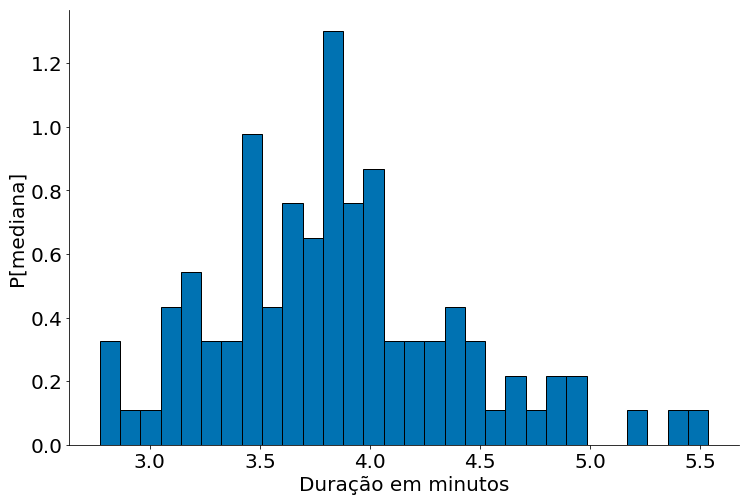

In [31]:
plt.hist(df['duration_m'], bins=30, edgecolor='k', density=True)
plt.xlabel('Duração em minutos')
plt.ylabel('P[mediana]')
despine()

A mediana foi de:

In [32]:
df['duration_m'].median()

3.8248833333333332

Se calcularmos a mediana do números de novas músicas para três amostras de 1000 elementos, teremos 3 resultados diferentes. Estamos usando 1000 pois é o mesmo tamanho da nossa **falsa** população. A ideia do bootstrap é usar amostras da amostra original como diferentes visões da população.

In [33]:
for _ in range(3):
    print(df.sample(len(df), replace=True).median())
    print()

duration_m    3.716225
dtype: float64

duration_m    3.781667
dtype: float64

duration_m    3.718667
dtype: float64



Se fizermos isso muitas vezes podemos ver como essa variação acontece. Em particular, vamos fazer 10000 vezes. Note que o código abaixo é essenciamente o mesmo da função `bootstrap` acima.

In [34]:
S = len(df)
N = 5000
values = np.zeros(N)
for i in range(N):
    sample = df.sample(S, replace=True)
    values[i] = sample.median()
print(values)

[ 3.73366667  3.71866667  3.78166667 ...,  3.87606667  3.87606667
  3.71866667]


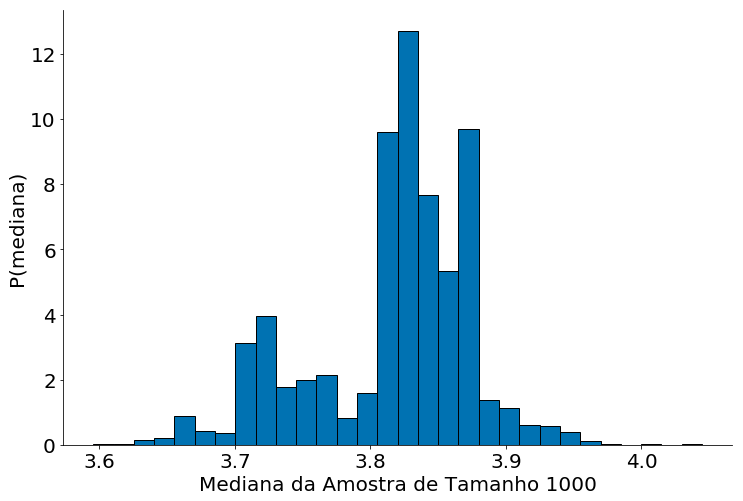

In [35]:
plt.hist(values, bins=30, edgecolor='k', density=True)
plt.xlabel('Mediana da Amostra de Tamanho 1000')
plt.ylabel('P(mediana)')
despine()

Usando a função score at percentile sabemos onde ficam 95% dos dados sintéticos.

In [36]:
np.percentile(values, 2.5)

3.6835083333333332

In [37]:
np.percentile(values, 97.5)

3.9137750000000002

Acamos de construir um **IC**.

Pegando por partes: 

 * Consideramos a amostra $A$ que tem tamanho $n$ como sendo um substituto da população  
 * Repetimos $b$ vezes o seguinte processo: criamos uma amostra de tamanho proporcional a $n$ obtendo elementos aleatoriamente de $A$, repondo cada elemento depois de cada sorteio. 
 * Calculamos a estatística $e$ que nos interessa (média, mediana, desvio padrão, o que for) para cada uma das $b$ amostras. 
 
Como resultado, sabemos como a estatística $e$ varia em uma simulação de $b$ amostragens. Podemos usar os percentis para criar um IC. Assim, se estimamos que em $P[E <= e_l] = 0.025$ e $P[E > e_h] = 0.025$ ou $P[E <= e_h] = 0.975$, nosso IC será: $(e - e_l, e + e_h)$.

1. Podemos usar bootstrap para tendências centrais não extremas.
1. O bootstrap falha quando os dados tem cauda pesada.

Um pouco de código de animações abaixo, pode ignorar o mesmo!

**Ingore daqui, caso queira**

In [38]:
def update_hist(num, data):
    plt.cla()
    plt.hist(data[0:100 * (num+1)], bins=20, density=True, edgecolor='k')
    plt.xlabel('Mediana da Amostra de Tamanho 1000')
    plt.ylabel('P(mediana)')
    despine()

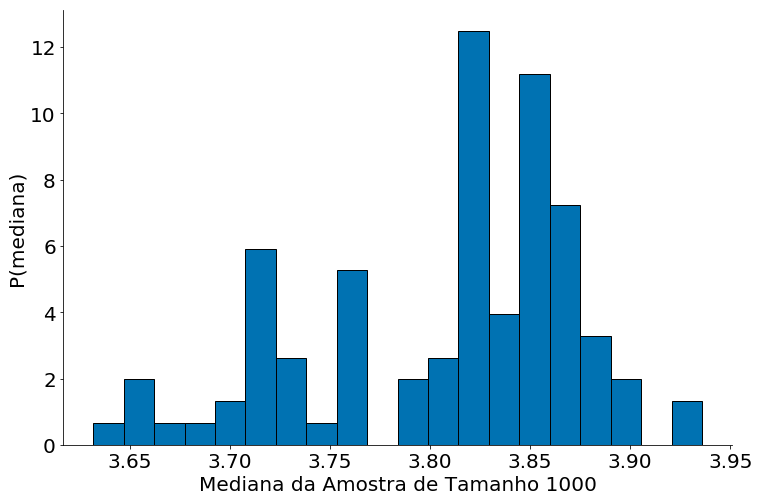

In [39]:
values = bootstrap_median(df)
fig = plt.figure()
ani = animation.FuncAnimation(fig, update_hist, 30, fargs=(values, ))
HTML(ani.to_html5_video())

**Até aqui!**

## Brincando com o bootstrap

E se a amostra fosse muito menor? Parece que temos alguns problemas! Voltamos a estimar o histograma, qual o motivo?

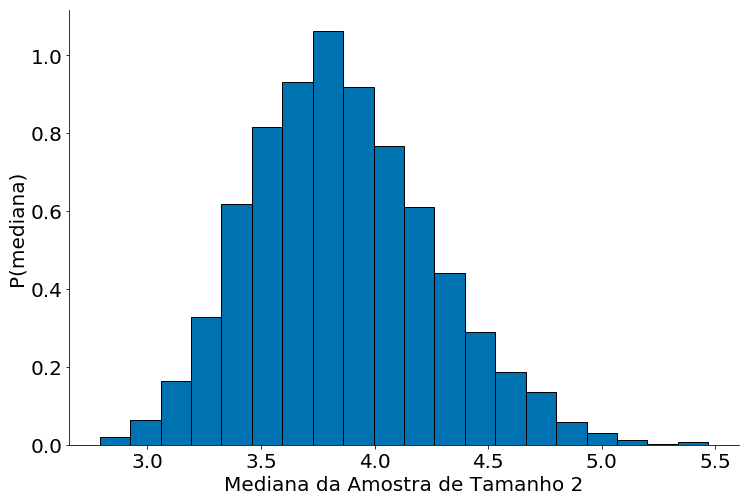

In [40]:
S = 2
N = 5000
values = bootstrap_median(df, size=S, n=N)
plt.hist(values, bins=20, density=True, edgecolor='k');
plt.xlabel('Mediana da Amostra de Tamanho 2')
plt.ylabel('P(mediana)')
despine()

No geral, devemos gerar amostras perto do tamanho da amostra original, ou pelo menos algum valor alto. Note que algumas centenas, neste caso, já se comporta similar ao caso com 1000.

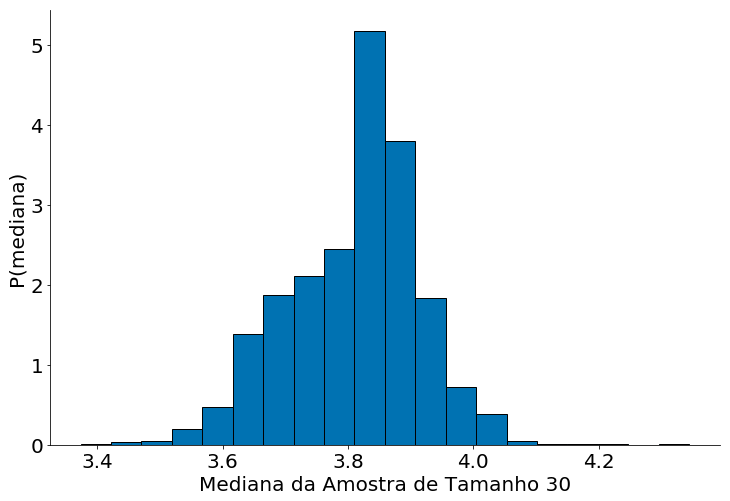

In [41]:
S = 30
N = 5000
values = bootstrap_median(df, size=S, n=N)
plt.hist(values, bins=20, density=True, edgecolor='k');
plt.xlabel('Mediana da Amostra de Tamanho 30')
plt.ylabel('P(mediana)')
despine()

Um novo problema. Se forem poucas amostras, mesmo sendo um `S` razoável?!

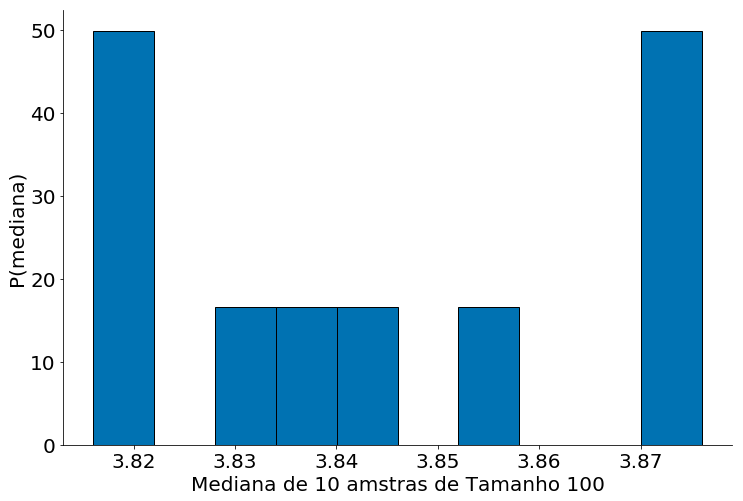

In [42]:
S = len(df)
N = 10
values = bootstrap_median(df, size=S, n=N)
plt.hist(values, bins=10, density=True, edgecolor='k');
plt.xlabel('Mediana de 10 amstras de Tamanho 100')
plt.ylabel('P(mediana)')
despine()

Gerando 2000 bootstraps e observar os que não capturam a mediana. O código abaixo demora usar um pouco de mágia numpy para executar de forma rápida.

## Comparando o Bootstrap com o caso Teórico

In [43]:
# voltando para as moedas

TAMANHO_AMOSTRA = 100
resultados = []
for i in range(TAMANHO_AMOSTRA):
    jogadas = np.random.randint(0, 2, size=30) # joga 30 moedas para cima
    n_caras = (jogadas == 1).sum()             # conta quantas foram == 1, caras
    resultados.append(n_caras)
resultados = np.array(resultados)

In [44]:
def bootstrap_mean(x, n=5000, size=None):
    if size is None:
        size = len(x)
    values = np.zeros(n)
    for i in range(n):
        sample = np.random.choice(x, size=size, replace=True)
        values[i] = sample.mean()
    return values

In [45]:
boot_samples = bootstrap_mean(resultados)

In [46]:
np.percentile(boot_samples, 2.5)

14.67

In [47]:
np.percentile(boot_samples, 97.5)

15.73

In [48]:
s = np.std(resultados, ddof=1)
s_over_n = s / np.sqrt(len(resultados))
mean = np.mean(resultados)

In [49]:
(mean - 1.96 * s_over_n, mean + 1.96 * s_over_n)

(14.656943182465492, 15.743056817534507)